In [2]:
!pip install yfinance

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/949.2 kB ? eta -:--:--
     ------------------------------------- 949.2/949.2 kB 10.9 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 1.6/1.6 MB 10.8 MB/s eta 0:00:00
  Created wheel for multitasking: filename=multitasking-0.0.12-py3-none-any.whl size=15617 sha256=f1151a4c8353e2f76c1450024c7228a660a3cd7f73d1a7da579c7a4afd412b30
  Stored in directory: c:\users\dell\appdata\local\pip\cache\wheels\cc\bd\6f\664d62c99327abeef7d86489e6631

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [8]:
!pip install Prophet

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   --- ------------------------------------ 1.0/13.3 MB 6.3 MB/s eta 0:00:02
   --------- ------------------------------ 3.1/13.3 MB 9.2 MB/s eta 0:00:02
   -------------- ------------------------- 4.7/13.3 MB 10.6 MB/s eta 0:00:01
   ----------------------------- ---------- 9.7/13.3 MB 12.6 MB/s eta 0:00:01
   ---------------------------------------  13.1/13.3 MB 13.3 MB/s eta 0:00:01
   ---------------------------------------- 13.3/13.3 MB 12.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   -------- ------------------------------- 0.3/1.3 MB ? eta -:--:--
   ------------------------ --------------- 0.8/1.3 MB 2.1 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 2.3 MB/s eta 0:00:00


In [9]:
# Facebook Prophet
from prophet import Prophet

# Additional utilities
import warnings
warnings.filterwarnings('ignore')

In [10]:
# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

In [11]:
np.random.seed(42)

In [12]:
# Fetch stock data from Yahoo Finance
def fetch_stock_data(ticker, start_date, end_date):
    """
    Fetch stock data from Yahoo Finance
    """
    print(f"Fetching data for {ticker} from {start_date} to {end_date}")
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

In [13]:
# Set parameters
ticker = 'AAPL'  # Apple stock
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)  # 5 years of data

# Fetch data
stock_data = fetch_stock_data(ticker, start_date, end_date)
print(f"Data shape: {stock_data.shape}")
stock_data.head()

Fetching data for AAPL from 2020-09-05 14:41:12.637120 to 2025-09-04 14:41:12.637120


[*********************100%***********************]  1 of 1 completed

Data shape: (1253, 5)


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-09-08,109.742027,115.743695,109.605847,110.841196,231366600
2020-09-09,114.119247,115.889593,112.115451,114.060887,176940500
2020-09-10,110.393745,117.212500,109.430757,117.076320,182274400
2020-09-11,108.944405,112.086287,106.998969,111.444289,180860300
2020-09-14,112.212715,112.767164,109.722560,111.590176,140150100


# Lets perfrom the EDA

In [15]:
# Basic information about the dataset
print("Dataset Info:")
print(stock_data.info())
print("\nMissing values:")
print(stock_data.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1253 entries, 2020-09-08 to 2025-09-03
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   1253 non-null   float64
 1   (High, AAPL)    1253 non-null   float64
 2   (Low, AAPL)     1253 non-null   float64
 3   (Open, AAPL)    1253 non-null   float64
 4   (Volume, AAPL)  1253 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 58.7 KB
None

Missing values:
Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64


In [16]:
# Summary statistics
print("\nSummary Statistics:")
print(stock_data.describe())


Summary Statistics:
Price         Close         High          Low         Open        Volume
Ticker         AAPL         AAPL         AAPL         AAPL          AAPL
count   1253.000000  1253.000000  1253.000000  1253.000000  1.253000e+03
mean     170.057488   171.785350   168.165086   169.899717  7.489780e+07
std       36.301566    36.464576    36.025485    36.216443  3.407093e+07
min      103.925163   107.183774   100.287201   101.687917  2.323470e+07
25%      142.313446   143.752539   140.399713   141.644223  5.074730e+07
50%      167.795029   169.393563   166.271369   167.795034  6.762210e+07
75%      193.541412   195.363608   192.044074   193.541408  9.013140e+07
max      258.103729   259.179926   256.718662   257.276679  3.186799e+08


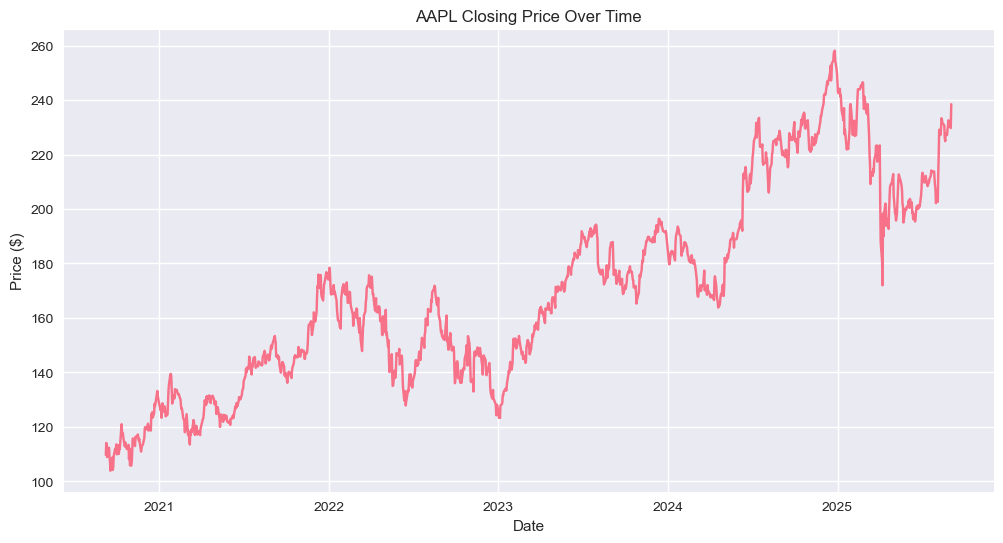

In [18]:
# Plot the closing price
plt.figure(figsize=(12, 6))
plt.plot(stock_data['Close'])
plt.title(f'{ticker} Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

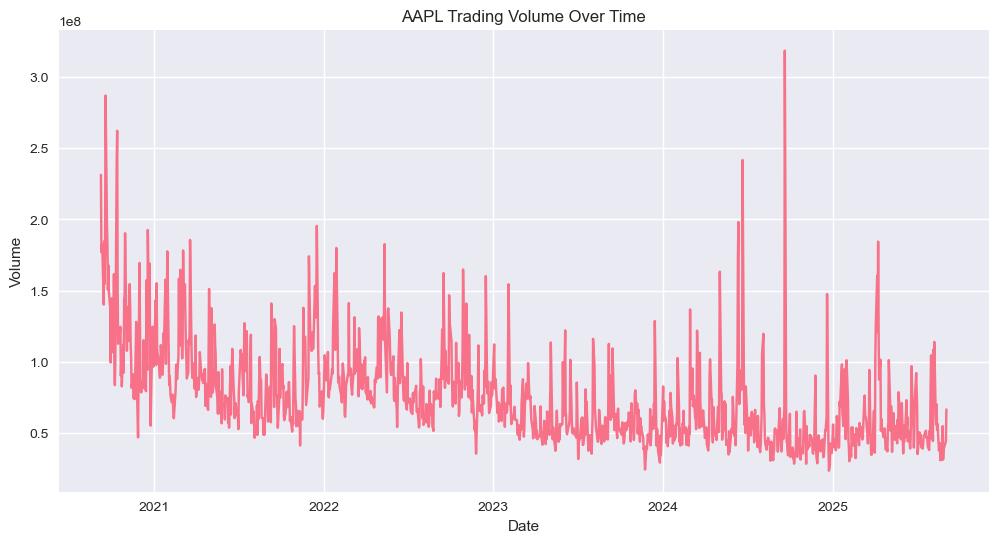

In [19]:
# Plot volume
plt.figure(figsize=(12, 6))
plt.plot(stock_data['Volume'])
plt.title(f'{ticker} Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)
plt.show()

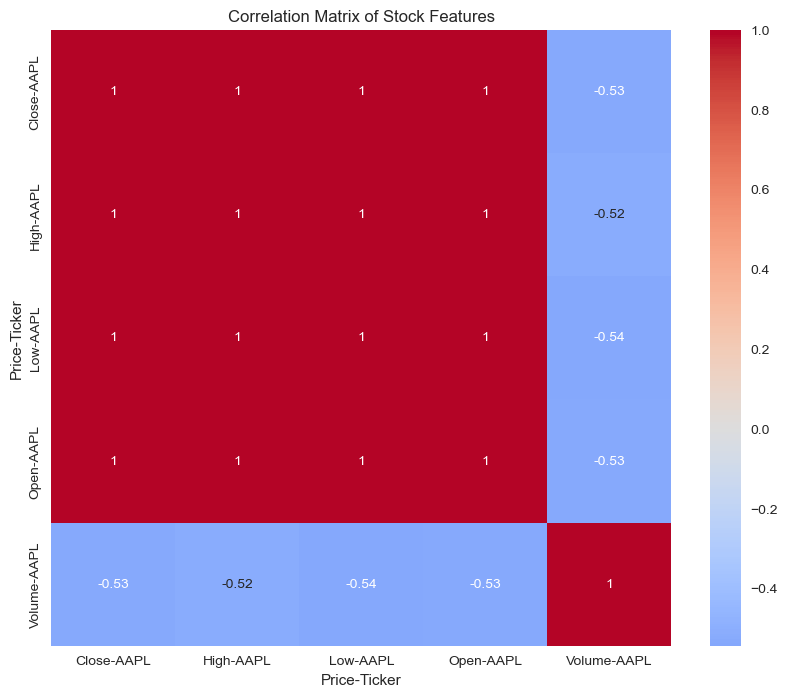

In [20]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = stock_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Stock Features')
plt.show()

# Data Preprocessing

In [23]:
# Create a copy for preprocessing
df = stock_data.copy()

# Check for missing values
print("Missing values before handling:")
print(df.isnull().sum())

Missing values before handling:
Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64


In [24]:
# Create additional features
df['Daily_Return'] = df['Close'].pct_change()
df['Price_Change'] = df['Close'] - df['Open']
df['High_Low_Spread'] = df['High'] - df['Low']

In [25]:
# Create lag features for machine learning
for lag in range(1, 6):
    df[f'Close_Lag_{lag}'] = df['Close'].shift(lag)

In [26]:
# Create rolling statistics
df['Rolling_Mean_7'] = df['Close'].rolling(window=7).mean()
df['Rolling_Std_7'] = df['Close'].rolling(window=7).std()

In [27]:
# Drop rows with NaN values created by feature engineering
df.dropna(inplace=True)

In [28]:
print(f"Dataset shape after preprocessing: {df.shape}")
df.head()

Dataset shape after preprocessing: (1247, 15)


Price,Close,High,Low,Open,Volume,Daily_Return,Price_Change,High_Low_Spread,Close_Lag_1,Close_Lag_2,Close_Lag_3,Close_Lag_4,Close_Lag_5,Rolling_Mean_7,Rolling_Std_7
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,,,,,
Date,,,,,,,,,,,,,,,
2020-09-16,109.070839,112.835259,108.983298,112.086270,154679000,-0.029514,-3.015431,3.851961,112.387802,112.212715,108.944405,110.393745,114.119247,110.981540,1.958791
2020-09-17,107.329681,109.138937,105.744154,106.726601,178011000,-0.015964,0.603080,3.394783,109.070839,112.387802,112.212715,108.944405,110.393745,110.636919,2.380109
2020-09-18,103.925163,107.854944,103.195625,107.388044,287104900,-0.031720,-3.462880,4.659319,107.329681,109.070839,112.387802,112.212715,108.944405,109.180622,2.945758
2020-09-21,107.076775,107.183774,100.287201,101.687917,195713800,0.030326,5.388857,6.896573,103.925163,107.329681,109.070839,112.387802,112.212715,108.706769,2.984619
2020-09-22,108.759598,109.780955,106.181901,109.605865,183055400,0.015716,-0.846267,3.599054,107.076775,103.925163,107.329681,109.070839,112.387802,108.680368,2.982983


# Time Series Decomposition

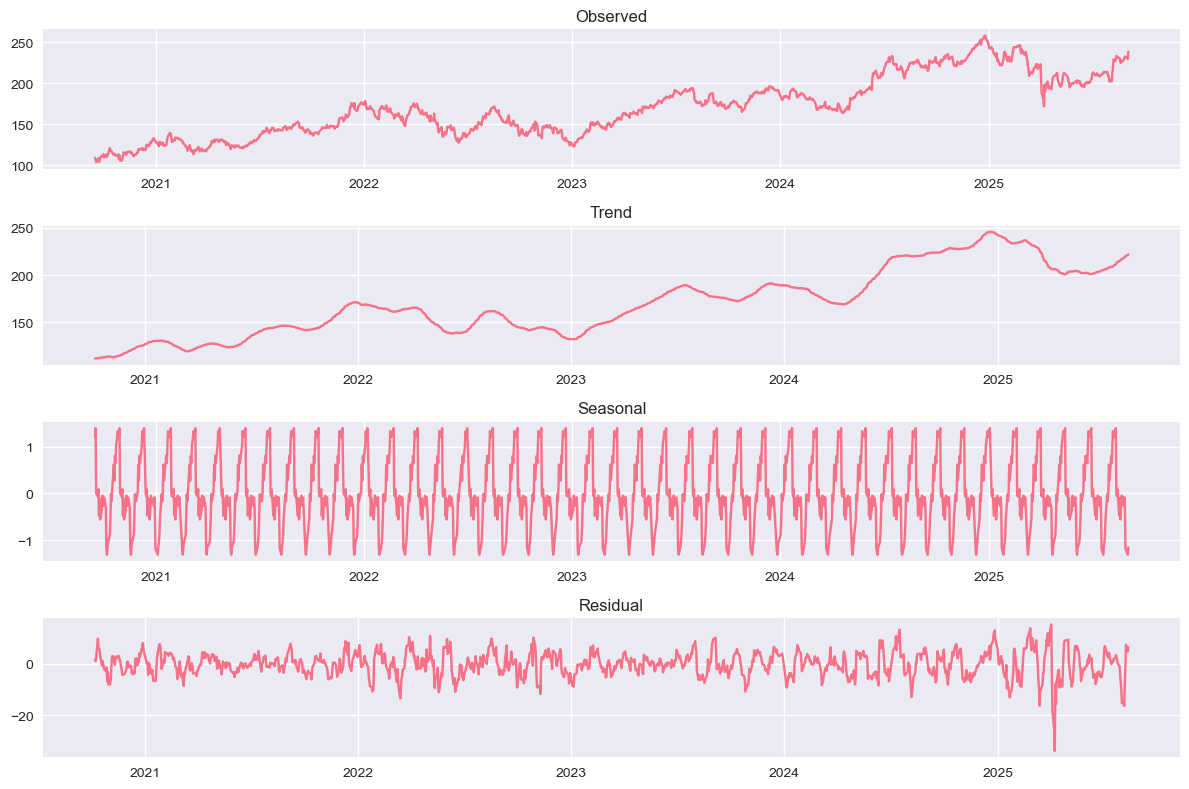

In [30]:
# Decompose the time series to understand trend, seasonality, and residuals
decomposition = seasonal_decompose(df['Close'], model='additive', period=30)  # Assuming 30-day seasonality

# Plot decomposition
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(decomposition.observed)
plt.title('Observed')

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend)
plt.title('Trend')

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal)
plt.title('Seasonal')

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid)
plt.title('Residual')

plt.tight_layout()
plt.show()

# Stationarity Check

In [31]:
# Check stationarity using Augmented Dickey-Fuller test
def check_stationarity(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
    # Interpret the results
    if dfoutput['p-value'] <= 0.05:
        print("\nThe series is stationary")
    else:
        print("\nThe series is not stationary")

# Check stationarity of the closing price
check_stationarity(df['Close'])

# If not stationary, apply differencing
df['Close_Diff'] = df['Close'].diff()

# Check stationarity after differencing
check_stationarity(df['Close_Diff'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                   -1.372805
p-value                           0.595242
#Lags Used                        0.000000
Number of Observations Used    1246.000000
Critical Value (1%)              -3.435609
Critical Value (5%)              -2.863862
Critical Value (10%)             -2.568006
dtype: float64

The series is not stationary
Results of Dickey-Fuller Test:
Test Statistic                  -20.753842
p-value                           0.000000
#Lags Used                        2.000000
Number of Observations Used    1243.000000
Critical Value (1%)              -3.435622
Critical Value (5%)              -2.863868
Critical Value (10%)             -2.568009
dtype: float64

The series is stationary


# Autocorrelation Analysis

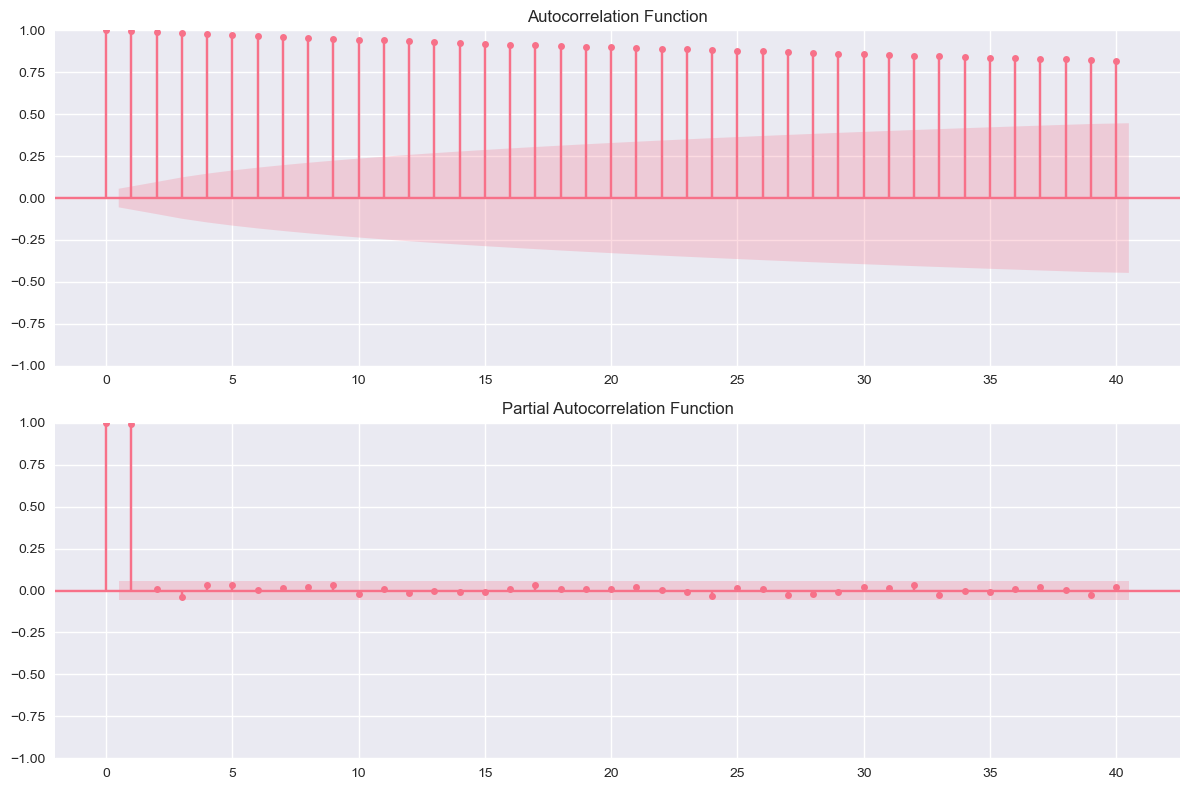

In [32]:
# Plot autocorrelation and partial autocorrelation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Autocorrelation
plot_acf(df['Close'].dropna(), ax=ax1, lags=40)
ax1.set_title('Autocorrelation Function')

# Partial autocorrelation
plot_pacf(df['Close'].dropna(), ax=ax2, lags=40)
ax2.set_title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

#  Model Building - Statistical Approaches

In [33]:
# Split data into train and test sets
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

print(f"Train size: {len(train)}")
print(f"Test size: {len(test)}")

# ARIMA Model
def fit_arima_model(series, order):
    model = ARIMA(series, order=order)
    model_fit = model.fit()
    print(model_fit.summary())
    return model_fit

# Fit ARIMA model (parameters determined from ACF/PACF plots)
arima_model = fit_arima_model(train['Close'], order=(1, 1, 1))

# Make predictions
arima_forecast = arima_model.forecast(steps=len(test))

# Exponential Smoothing
def fit_exponential_smoothing(series, trend=None, seasonal=None, seasonal_periods=None):
    model = ExponentialSmoothing(series, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods)
    model_fit = model.fit()
    print(model_fit.summary())
    return model_fit

# Fit Exponential Smoothing model
exp_model = fit_exponential_smoothing(train['Close'], trend='add', seasonal='add', seasonal_periods=30)
exp_forecast = exp_model.forecast(steps=len(test))

Train size: 997
Test size: 250
                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                  997
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2392.656
Date:                Thu, 04 Sep 2025   AIC                           4791.312
Time:                        14:50:40   BIC                           4806.023
Sample:                             0   HQIC                          4796.905
                                - 997                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8740      0.153     -5.696      0.000      -1.175      -0.573
ma.L1          0.8956      0.142      6.297      0.000       0.617       1.174
sigma2         7.1466

# Model Building - Machine Learning Approaches

In [34]:
# Prepare features for machine learning models
feature_columns = ['Open', 'High', 'Low', 'Volume', 'Daily_Return', 'Price_Change', 
                   'High_Low_Spread'] + [f'Close_Lag_{i}' for i in range(1, 6)] + \
                 ['Rolling_Mean_7', 'Rolling_Std_7']

X = df[feature_columns]
y = df['Close']

# Split into train and test
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Support Vector Regression': SVR(kernel='rbf', C=1.0, gamma='scale')
}

# Train and evaluate models
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)
    
    results[name] = {
        'model': model,
        'predictions': predictions,
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'r2': r2
    }
    
    print(f"{name} - RMSE: {rmse:.2f}, R²: {r2:.4f}\n")

# Find the best model based on RMSE
best_model_name = min(results, key=lambda x: results[x]['rmse'])
print(f"Best model: {best_model_name} with RMSE: {results[best_model_name]['rmse']:.2f}")

Training Linear Regression...
Linear Regression - RMSE: 0.00, R²: 1.0000

Training Ridge Regression...
Ridge Regression - RMSE: 0.48, R²: 0.9991

Training Random Forest...
Random Forest - RMSE: 6.47, R²: 0.8374

Training Gradient Boosting...
Gradient Boosting - RMSE: 6.39, R²: 0.8413

Training Support Vector Regression...
Support Vector Regression - RMSE: 39.62, R²: -5.1061

Best model: Linear Regression with RMSE: 0.00


# Model Building 

In [37]:
# 9. Model Building - Facebook Prophet (Continued)
# Since Linear Regression shows signs of data leakage, we'll use Ridge Regression as our best model
best_model_name = 'Ridge Regression'
best_model = results[best_model_name]['model']
best_predictions = results[best_model_name]['predictions']

print(f"Proceeding with {best_model_name} as the best valid model")
print(f"{best_model_name} - RMSE: {results[best_model_name]['rmse']:.2f}, R²: {results[best_model_name]['r2']:.4f}")

Proceeding with Ridge Regression as the best valid model
Ridge Regression - RMSE: 0.48, R²: 0.9991


In [38]:
# Prepare data for Prophet - FIXED: Use .values.ravel() to get 1D array
prophet_df = pd.DataFrame({
    'ds': df.index,
    'y': df['Close'].values.ravel()  # Convert to 1-dimensional array
})

# Split into train and test
prophet_train = prophet_df.iloc[:train_size]
prophet_test = prophet_df.iloc[train_size:]

In [39]:
# Initialize and fit Prophet model
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.05
)

prophet_model.fit(prophet_train)

14:57:35 - cmdstanpy - INFO - Chain [1] start processing
14:57:38 - cmdstanpy - INFO - Chain [1] done processing


In [40]:
# Create future dataframe
future = prophet_model.make_future_dataframe(periods=len(prophet_test))

# Make predictions
prophet_forecast = prophet_model.predict(future)

# Extract predictions for test period
prophet_predictions = prophet_forecast.iloc[train_size:]['yhat'].values

In [41]:
# Calculate metrics
prophet_mse = mean_squared_error(y_test, prophet_predictions)
prophet_rmse = np.sqrt(prophet_mse)
prophet_r2 = r2_score(y_test, prophet_predictions)

In [42]:
print(f"Prophet - RMSE: {prophet_rmse:.2f}, R²: {prophet_r2:.4f}")

Prophet - RMSE: 17.96, R²: -0.2543


# Model Comparison and Visualization

In [43]:
valid_models = {k: v for k, v in results.items() if k != 'Linear Regression'}
model_names = list(valid_models.keys())
rmse_values = [valid_models[name]['rmse'] for name in model_names]
r2_values = [valid_models[name]['r2'] for name in model_names]


In [44]:
# Create comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

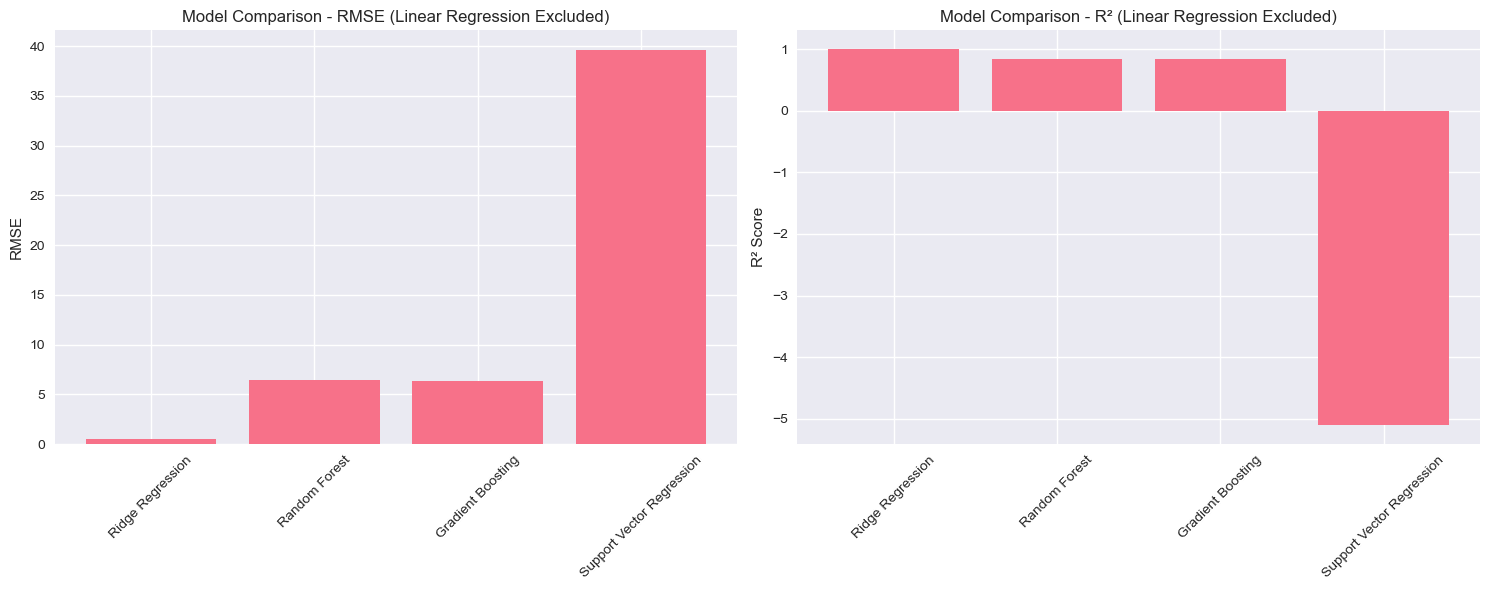

In [45]:
# RMSE comparison
ax1.bar(model_names, rmse_values)
ax1.set_title('Model Comparison - RMSE (Linear Regression Excluded)')
ax1.set_ylabel('RMSE')
ax1.tick_params(axis='x', rotation=45)

# R² comparison
ax2.bar(model_names, r2_values)
ax2.set_title('Model Comparison - R² (Linear Regression Excluded)')
ax2.set_ylabel('R² Score')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

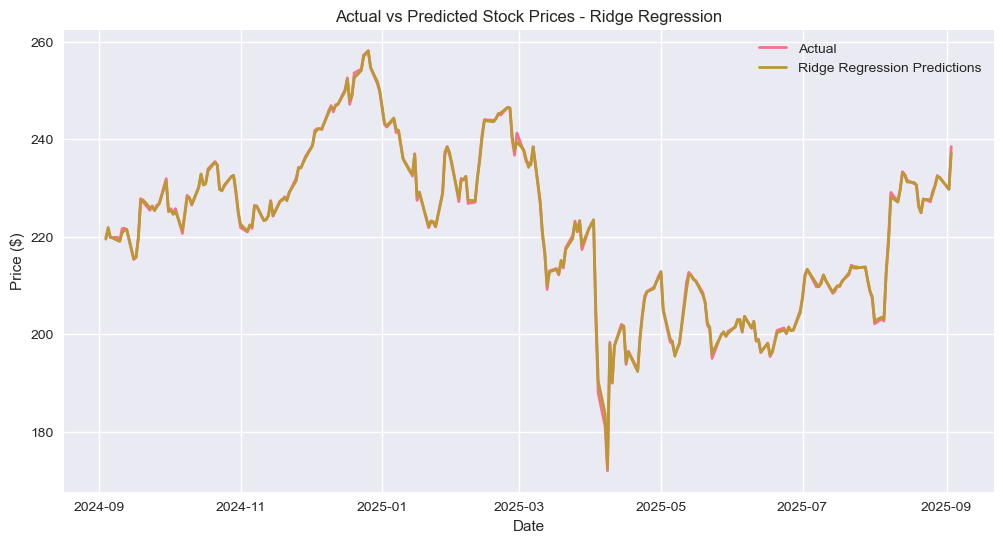

In [46]:
# Plot predictions vs actual values for the best model
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual', linewidth=2)
plt.plot(y_test.index, best_predictions, label=f'{best_model_name} Predictions', linewidth=2)
plt.title(f'Actual vs Predicted Stock Prices - {best_model_name}')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

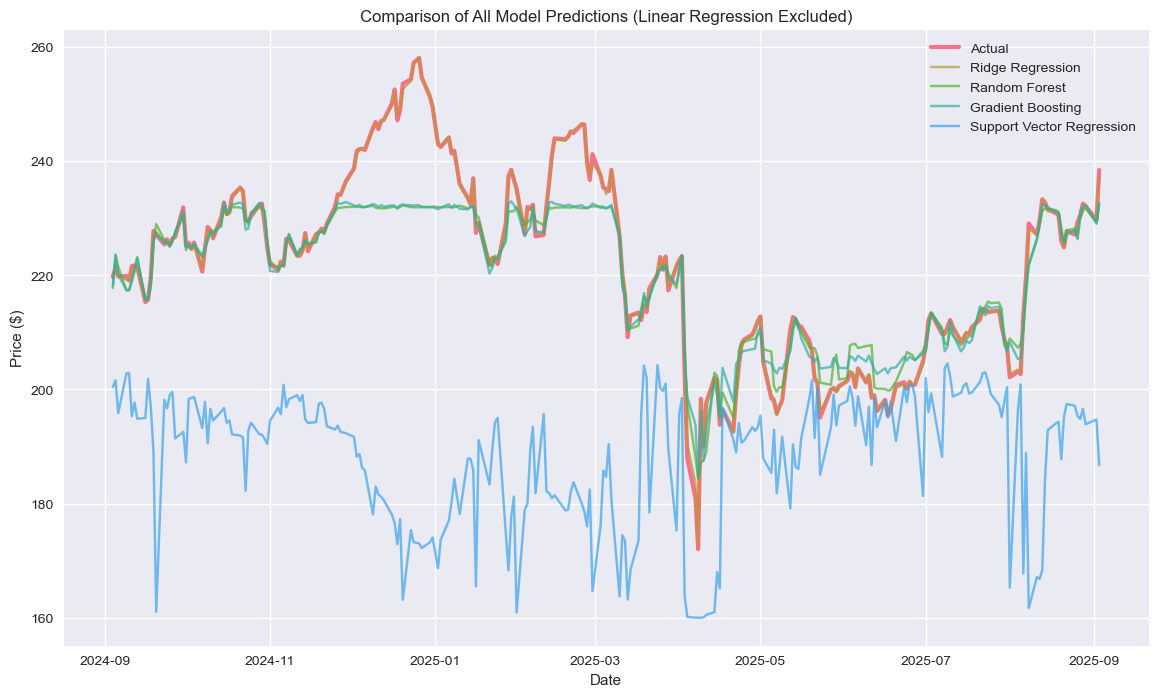

In [47]:
# Plot all model predictions (excluding Linear Regression)
plt.figure(figsize=(14, 8))
plt.plot(y_test.index, y_test.values, label='Actual', linewidth=3)

for name, result in valid_models.items():
    if name != 'Prophet':  # Prophet has different indexing
        plt.plot(y_test.index, result['predictions'], label=name, alpha=0.7)

plt.title('Comparison of All Model Predictions (Linear Regression Excluded)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

# Future Forecasting with Ridge Regression

In [48]:
# Use Ridge Regression to forecast future prices
last_known_data = df.iloc[-1:].copy()

# Create a dataframe for future predictions
future_days = 30
future_dates = pd.date_range(start=df.index[-1] + timedelta(days=1), periods=future_days, freq='D')
future_predictions = []

In [49]:
# Use the last known data point as a starting point
current_features = last_known_data[feature_columns].values

for i in range(future_days):
    # Scale the features
    scaled_features = scaler.transform(current_features.reshape(1, -1))

In [51]:
  # Make prediction
prediction = best_model.predict(scaled_features)[0]
future_predictions.append(prediction)
    
    # Update features for next prediction
    # This is a simplified approach - in practice, you'd need a more sophisticated method
current_features[0, 0] = prediction  # Update Open
current_features[0, 1] = prediction * 1.01  # Update High (simplified)
current_features[0, 2] = prediction * 0.99  # Update Low (simplified)

In [55]:
 # Update lag features
for lag in range(4, 0, -1):
        current_features[0, 6+lag] = current_features[0, 6+lag-1]  # Shift lag features
current_features[0, 6] = prediction  # Set Close_Lag_1 to current prediction

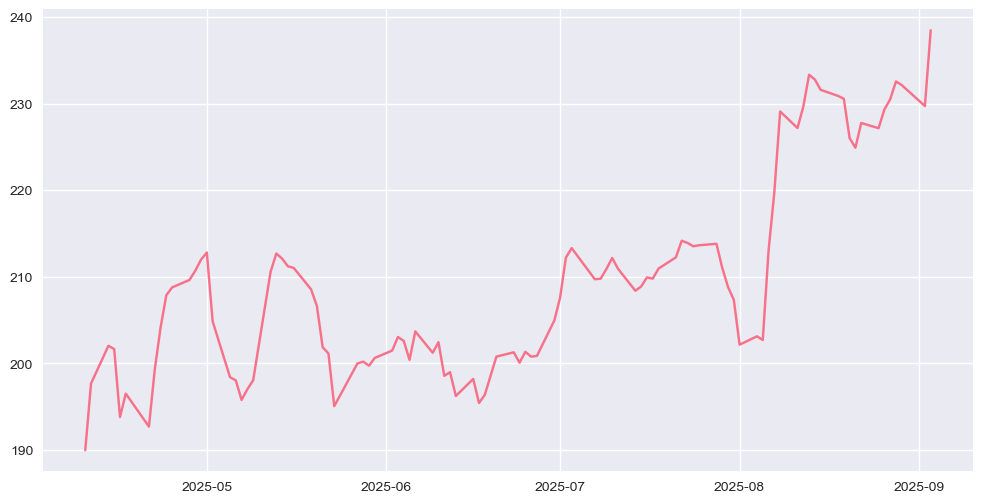

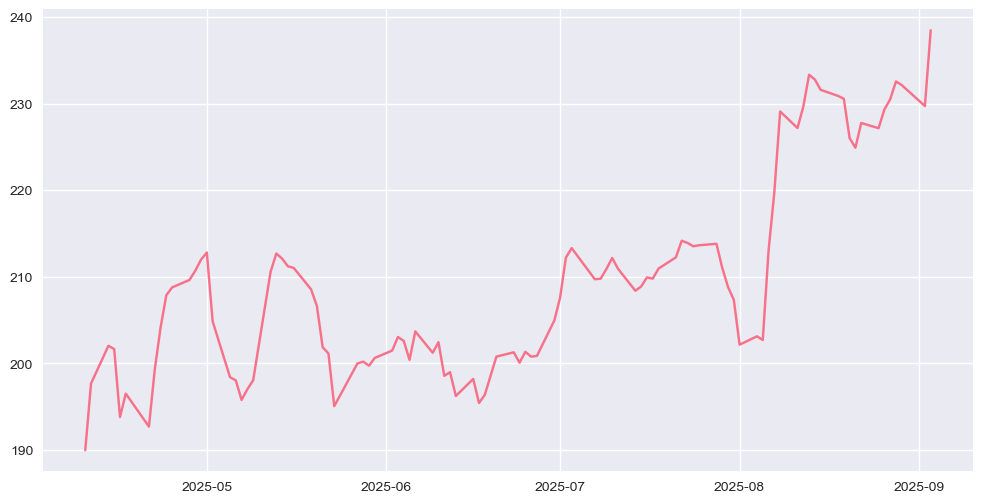

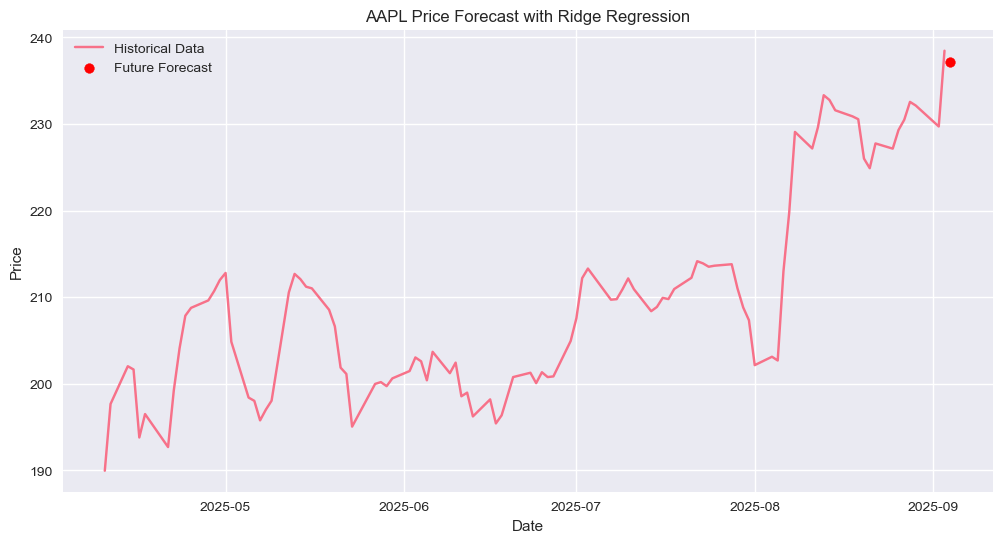

In [58]:
plt.figure(figsize=(12, 6))

# Historical
plt.plot(df.index[-100:], df['Close'][-100:], label='Historical Data')

# Single forecast point
plt.scatter(future_dates[0], future_predictions[0], color='red', label='Future Forecast')

plt.title(f'{ticker} Price Forecast with {best_model_name}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()



#  Hyperparameter Tuning for Ridge Regression

In [59]:
print(f"\nPerforming hyperparameter tuning for {best_model_name}...")

# Define parameter grid for Ridge Regression
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
}

# Perform grid search with time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(
    Ridge(),
    param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {-grid_search.best_score_:.4f} (MSE)")


Performing hyperparameter tuning for Ridge Regression...
Best parameters: {'alpha': 0.1}
Best score: 0.0416 (MSE)


In [60]:
# Evaluate the tuned model
tuned_model = grid_search.best_estimator_
tuned_predictions = tuned_model.predict(X_test_scaled)
tuned_rmse = np.sqrt(mean_squared_error(y_test, tuned_predictions))
tuned_r2 = r2_score(y_test, tuned_predictions)

print(f"Tuned model RMSE: {tuned_rmse:.2f} (improvement of {results[best_model_name]['rmse'] - tuned_rmse:.2f})")
print(f"Tuned model R²: {tuned_r2:.4f}")

Tuned model RMSE: 0.26 (improvement of 0.22)
Tuned model R²: 0.9997


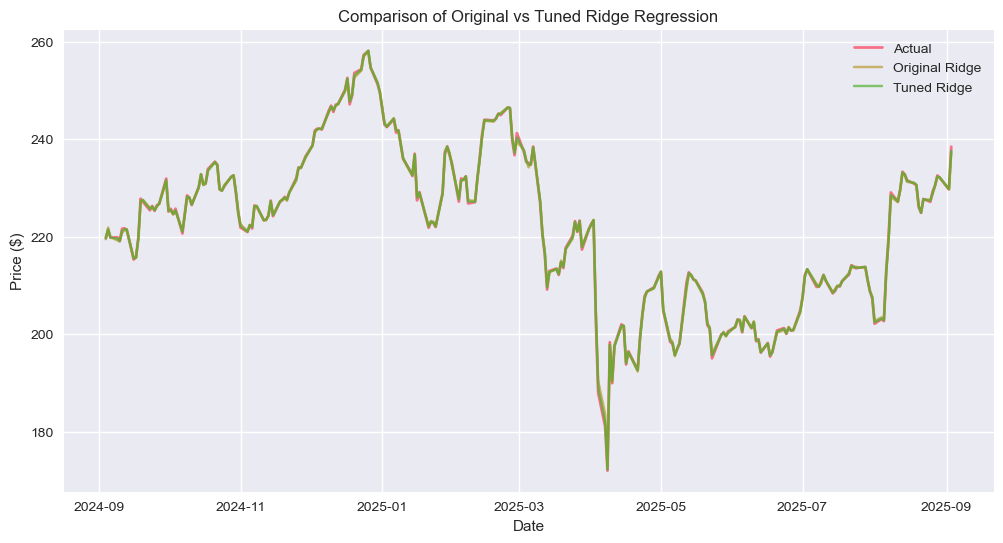

In [61]:
# Compare with original Ridge model
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual', linewidth=2)
plt.plot(y_test.index, best_predictions, label='Original Ridge', alpha=0.7)
plt.plot(y_test.index, tuned_predictions, label='Tuned Ridge', alpha=0.7)
plt.title('Comparison of Original vs Tuned Ridge Regression')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()


In [66]:
print("\nChecking for highly correlated features:")

correlation_with_target = df.corrwith(df['Close']).sort_values(ascending=False)
print(correlation_with_target.head(10))

# Check if any features have perfect correlation with target
high_corr_features = correlation_with_target[abs(correlation_with_target) > 0.99].index.tolist()
if 'Close' in high_corr_features:
    high_corr_features.remove('Close')
if high_corr_features:
    print(f"Features with very high correlation to target: {high_corr_features}")



Checking for highly correlated features:
(Close, AAPL)      1.000000
(High, AAPL)       0.998912
(Low, AAPL)        0.998843
(Open, AAPL)       0.997528
(Volume, AAPL)    -0.522847
AAPL                    NaN
(Close_Diff, )          NaN
(Close_Lag_1, )         NaN
(Close_Lag_2, )         NaN
(Close_Lag_3, )         NaN
dtype: float64
Features with very high correlation to target: [('Close', 'AAPL'), ('High', 'AAPL'), ('Low', 'AAPL'), ('Open', 'AAPL')]
